In [16]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import os

In [17]:
LR = 1e-4
BS = 32
EP = 30

In [18]:
labels = []
data = [] 

In [19]:
DIR = r"dataset"
CAT = ['mask_off', 'mask_on']

In [20]:
print("Loading Images")
for cat in CAT:
    path = os.path.join(DIR,cat)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(cat)

print("Images loaded")

Loading Images


C:\Users\shrin\.conda\envs\tfgpu\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Images loaded


In [5]:
#For inceptionV3
print("Loading Images")
for cat in CAT:
    path = os.path.join(DIR,cat)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(299,299))
        
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(cat)

print("Images loaded")

Loading Images


C:\Users\shrin\.conda\envs\tfgpu\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Images loaded


In [21]:
#One hot encoding labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)


In [22]:
(trainX, testX, trainY, testY) = train_test_split(data,
                                                  labels,
                                                  test_size=0.20,
                                                  stratify=labels,
                                                  random_state=42)

In [23]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [9]:
import tensorflow as tf
from tensorflow import keras
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=1, mode='auto',
    baseline=None, restore_best_weights=False
)

In [9]:
#load into MobileNetV2
baseModel = NASNetMobile(weights="imagenet", 
                        include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

In [11]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
baseModel = InceptionV3(weights="imagenet", 
                        include_top=False,
                        input_tensor=Input(shape=(299,299, 3)))

In [24]:
baseModel = MobileNetV2(weights="imagenet", 
                        include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

C:\Users\shrin\.conda\envs\tfgpu\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [25]:
myModel = baseModel.output

myModel = AveragePooling2D(pool_size=(7, 7))(myModel)
myModel = Flatten(name="flatten")(myModel)
myModel = Dense(128, activation="relu")(myModel)

myModel = Dense(128, activation="relu")(myModel)

myModel = Dropout(0.5)(myModel)


myModel = Dense(2, activation="softmax")(myModel)


model = Model(inputs=baseModel.input, outputs=myModel)

for layer in baseModel.layers:
    layer.trainable = False

In [26]:
opt = Adam(lr=LR, decay=LR/EP)
model.compile(loss="binary_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

In [27]:
# history = model.fit(
#     aug.flow(trainX, trainY, batch_size=BS),
#     steps_per_epoch=len(trainX) // BS,
#     validation_data=(testX, testY),
#     validation_steps=len(testX) // BS,
#     epochs=EP)
hist = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EP,)

  ...
    to  
  ['...']
Train for 95 steps, validate on 767 samples
Epoch 1/30
95/95 [==============================] - 29s 306ms/step - loss: 0.5732 - accuracy: 0.6964 - val_loss: 0.5113 - val_accuracy: 0.7201
Epoch 2/30
95/95 [==============================] - 26s 278ms/step - loss: 0.3024 - accuracy: 0.8883 - val_loss: 0.4043 - val_accuracy: 0.8356
Epoch 3/30
95/95 [==============================] - 26s 270ms/step - loss: 0.1985 - accuracy: 0.9288 - val_loss: 0.2231 - val_accuracy: 0.8981
Epoch 4/30
95/95 [==============================] - 26s 269ms/step - loss: 0.1593 - accuracy: 0.9436 - val_loss: 0.3233 - val_accuracy: 0.8872
Epoch 5/30
95/95 [==============================] - 26s 271ms/step - loss: 0.1387 - accuracy: 0.9483 - val_loss: 0.4103 - val_accuracy: 0.8655
Epoch 6/30
95/95 [==============================] - 26s 272ms/step - loss: 0.1199 - accuracy: 0.9562 - val_loss: 0.3391 - val_accuracy: 0.8899
Epoch 7/30
95/95 [==============================] - 26s 271ms/step - loss

              precision    recall  f1-score   support

    mask_off       0.96      0.98      0.97       384
     mask_on       0.98      0.96      0.97       383

    accuracy                           0.97       767
   macro avg       0.97      0.97      0.97       767
weighted avg       0.97      0.97      0.97       767



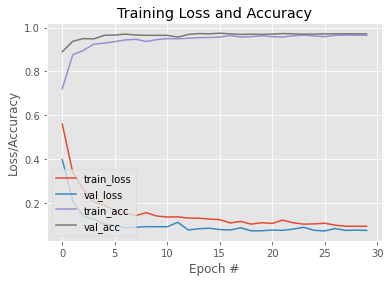

In [14]:
#Eval
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

# serialize the model to disk
model.save("mask_detector_NASNet.model", save_format="h5")

# plot the training loss and accuracy
N = EP
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label="val_acc")


plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("NASNetMobile-plot.png")

              precision    recall  f1-score   support

    mask_off       0.96      1.00      0.98       384
     mask_on       1.00      0.96      0.98       383

    accuracy                           0.98       767
   macro avg       0.98      0.98      0.98       767
weighted avg       0.98      0.98      0.98       767



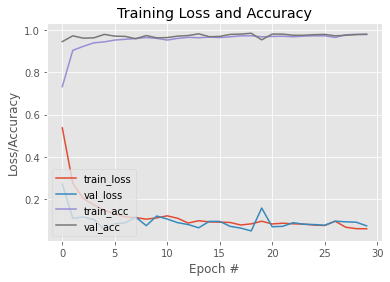

In [15]:
#Eval
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

# serialize the model to disk
model.save("mask_detector_InceptionV3.model", save_format="h5")

# plot the training loss and accuracy
N = EP
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label="val_acc")


plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("Inception-plot.png")

              precision    recall  f1-score   support

    mask_off       0.89      0.98      0.94       384
     mask_on       0.98      0.88      0.93       383

    accuracy                           0.93       767
   macro avg       0.94      0.93      0.93       767
weighted avg       0.94      0.93      0.93       767



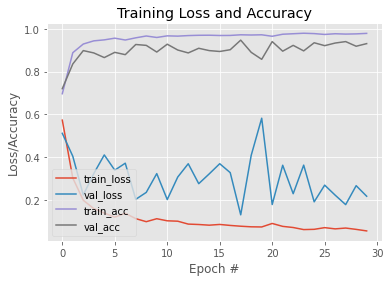

In [28]:
#Eval
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

# serialize the model to disk
model.save("mask_detector_MobileNetV2.model", save_format="h5")

# plot the training loss and accuracy
N = EP
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label="val_acc")


plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("MobileNetV2-plot.png")

In [16]:
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import imutils
import time
import cv2
import os

def detect_predict(frame, faceNet, maskNet):
	# Get dimension and create blob
	
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)
prototxtPath = r"detect_face\deploy.prototxt"
weightsPath = r"detect_face\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

maskNet = load_model('mask_detector_InceptionV3.model')

cap = VideoStream().start()

while True:
    frame = cap.read()
    frame = imutils.resize(frame,width=600,height=800)

        #Pass to detector model to  id face and check mask
    (locs, preds) = detect_predict(frame,faceNet,maskNet)
    for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
        (startX, startY, endX, endY)= box
        print("Mask ",pred[0])
        (withoutMask,mask) = pred

		# determine the class label and color we'll use to draw
        label = "No Mask" if withoutMask > mask else "Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # display the label and bounding box rectangle on the output
        cv2.putText(frame, label, (startX, startY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    if key == ord("q"):
        break
cv2.destroyAllWindows()
cap.stop()

(1, 1, 200, 7)
Mask  0.9767444
Mask  0.013372194
(1, 1, 200, 7)
Mask  0.8356228
Mask  0.9884664
(1, 1, 200, 7)
Mask  0.98941004
Mask  0.99338657
(1, 1, 200, 7)
Mask  0.99876225
Mask  0.9901889
(1, 1, 200, 7)
Mask  0.99533045
Mask  0.9960944
(1, 1, 200, 7)
Mask  0.9979175
Mask  0.9941103
(1, 1, 200, 7)
Mask  0.99142987
Mask  0.99054027
(1, 1, 200, 7)
Mask  0.9891071
Mask  0.9915503
(1, 1, 200, 7)
Mask  0.9975297
Mask  0.9794409
(1, 1, 200, 7)
Mask  0.99610573
Mask  0.98222685
(1, 1, 200, 7)
Mask  0.9992205
Mask  0.9871415
(1, 1, 200, 7)
Mask  0.9969163
Mask  0.984127
(1, 1, 200, 7)
Mask  0.981294
Mask  0.9904156
(1, 1, 200, 7)
Mask  0.99471444
Mask  0.973976
(1, 1, 200, 7)
Mask  0.97547126
Mask  0.9991767
(1, 1, 200, 7)
Mask  0.99359035
Mask  0.9977283
(1, 1, 200, 7)
Mask  0.97590035
Mask  0.99762875
(1, 1, 200, 7)
Mask  0.98874205
Mask  0.9961356
(1, 1, 200, 7)
Mask  0.9881975
Mask  0.99621046
(1, 1, 200, 7)
Mask  0.9893233
Mask  0.99643326
(1, 1, 200, 7)
Mask  0.99105835
Mask  0.99834

(1, 1, 200, 7)
Mask  0.00019315256
Mask  0.99803954
(1, 1, 200, 7)
Mask  0.0004179834
Mask  0.9993666
(1, 1, 200, 7)
Mask  0.00023994065
Mask  0.9756236
(1, 1, 200, 7)
Mask  0.00026319092
Mask  0.8901735
(1, 1, 200, 7)
Mask  0.000332538
Mask  0.94619155
(1, 1, 200, 7)
Mask  0.0002581826
Mask  0.9902457
(1, 1, 200, 7)
Mask  0.00026498816
Mask  0.8509953
(1, 1, 200, 7)
Mask  0.00019027157
Mask  0.99305457
(1, 1, 200, 7)
Mask  0.00026021598
Mask  0.9954928
(1, 1, 200, 7)
Mask  0.00029939192
Mask  0.98643976
(1, 1, 200, 7)
Mask  0.00064970343
Mask  0.9919797
(1, 1, 200, 7)
Mask  0.00038195698
Mask  0.989263
(1, 1, 200, 7)
Mask  0.00015589524
Mask  0.9621564
(1, 1, 200, 7)
Mask  0.00012686763
Mask  0.9943089
(1, 1, 200, 7)
Mask  0.00053674943
Mask  0.9907515
(1, 1, 200, 7)
Mask  0.00038104662
Mask  0.9928599
(1, 1, 200, 7)
Mask  0.0005013637
Mask  0.9897741
(1, 1, 200, 7)
Mask  0.0002920985
Mask  0.99372214
(1, 1, 200, 7)
Mask  0.00018509508
Mask  0.995426
(1, 1, 200, 7)
Mask  6.954684e-05


(1, 1, 200, 7)
Mask  0.0005171968
Mask  0.99991775
(1, 1, 200, 7)
Mask  0.00034093342
Mask  0.99989164
(1, 1, 200, 7)
Mask  0.00076449045
Mask  0.9994797
(1, 1, 200, 7)
Mask  0.00062950567
Mask  0.99980813
(1, 1, 200, 7)
Mask  0.00014047329
Mask  0.99981827
(1, 1, 200, 7)
Mask  0.0007156351
Mask  0.9997577
(1, 1, 200, 7)
Mask  0.000512327
Mask  0.9996061
(1, 1, 200, 7)
Mask  0.0008146317
Mask  0.9995658
(1, 1, 200, 7)
Mask  0.00063336955
Mask  0.99970406
(1, 1, 200, 7)
Mask  0.0011208454
Mask  0.9989403
(1, 1, 200, 7)
Mask  0.00037407278
Mask  0.99962974
(1, 1, 200, 7)
Mask  0.0009641185
Mask  0.9993193
(1, 1, 200, 7)
Mask  0.0013883475
Mask  0.99950707
(1, 1, 200, 7)
Mask  0.00094793376
Mask  0.99971384
(1, 1, 200, 7)
Mask  0.002165077
Mask  0.9998385
(1, 1, 200, 7)
Mask  0.00036069006
Mask  0.99937457
(1, 1, 200, 7)
Mask  0.0005031437
Mask  0.99987984
(1, 1, 200, 7)
Mask  0.0029714196
Mask  0.99984574
(1, 1, 200, 7)
Mask  0.00023702295
Mask  0.99988425
(1, 1, 200, 7)
Mask  0.00029152

Mask  0.012242751
(1, 1, 200, 7)
Mask  0.00728085
(1, 1, 200, 7)
Mask  0.013858031
(1, 1, 200, 7)
Mask  0.00443718
(1, 1, 200, 7)
Mask  0.0053968416
(1, 1, 200, 7)
Mask  0.011383266
(1, 1, 200, 7)
Mask  0.009826422
(1, 1, 200, 7)
Mask  0.02701113
(1, 1, 200, 7)
Mask  0.005760967
(1, 1, 200, 7)
Mask  0.012915717
(1, 1, 200, 7)
Mask  0.005068987
(1, 1, 200, 7)
Mask  0.015847392
(1, 1, 200, 7)
Mask  0.0040907324
(1, 1, 200, 7)
Mask  0.0060981982
(1, 1, 200, 7)
Mask  0.02212646
(1, 1, 200, 7)
Mask  0.0043721017
(1, 1, 200, 7)
Mask  0.003953859
(1, 1, 200, 7)
Mask  0.004644283
(1, 1, 200, 7)
Mask  0.004941932
(1, 1, 200, 7)
Mask  0.0044636694
(1, 1, 200, 7)
Mask  0.006412246
(1, 1, 200, 7)
Mask  0.0070705307
(1, 1, 200, 7)
Mask  0.015436186
(1, 1, 200, 7)
Mask  0.012205269
(1, 1, 200, 7)
Mask  0.014217399
(1, 1, 200, 7)
Mask  0.021630162
(1, 1, 200, 7)
Mask  0.005811135
(1, 1, 200, 7)
Mask  0.0065414207
(1, 1, 200, 7)
Mask  0.008798441
(1, 1, 200, 7)
Mask  0.01177043
(1, 1, 200, 7)
Mask  0.

Mask  0.9967654
Mask  0.99942434
(1, 1, 200, 7)
Mask  0.9955994
Mask  0.9996705
(1, 1, 200, 7)
Mask  0.99513197
Mask  0.9987099
(1, 1, 200, 7)
Mask  0.9974886
Mask  0.99862766
(1, 1, 200, 7)
Mask  0.99884355
Mask  0.99822587
(1, 1, 200, 7)
Mask  0.9992987
Mask  0.99628747
(1, 1, 200, 7)
Mask  0.99806017
Mask  0.99827254
(1, 1, 200, 7)
Mask  0.99672973
Mask  0.99799746
(1, 1, 200, 7)
Mask  0.9989982
Mask  0.9968747
(1, 1, 200, 7)
Mask  0.99756587
Mask  0.99695957
(1, 1, 200, 7)
Mask  0.9984756
Mask  0.9990213
(1, 1, 200, 7)
Mask  0.9988207
Mask  0.99276745
(1, 1, 200, 7)
Mask  0.99719894
Mask  0.99917895
(1, 1, 200, 7)
Mask  0.99831414
Mask  0.9996805
(1, 1, 200, 7)
Mask  0.9911368
Mask  0.99778205
(1, 1, 200, 7)
Mask  0.9989195
Mask  0.92975116
(1, 1, 200, 7)
Mask  0.9982418
(1, 1, 200, 7)
Mask  0.99805105
(1, 1, 200, 7)
Mask  0.99938273
(1, 1, 200, 7)
Mask  0.99884903
(1, 1, 200, 7)
Mask  0.99932647
(1, 1, 200, 7)
Mask  0.9982066
(1, 1, 200, 7)
Mask  0.9987179
Mask  0.99066144
(1, 1, 

Mask  0.98076886
(1, 1, 200, 7)
Mask  0.99393326
(1, 1, 200, 7)
Mask  0.8522159
(1, 1, 200, 7)
Mask  0.8263022
(1, 1, 200, 7)
Mask  0.5297693
(1, 1, 200, 7)
Mask  0.20743494
(1, 1, 200, 7)
Mask  0.9437098
(1, 1, 200, 7)
Mask  0.98604625
(1, 1, 200, 7)
Mask  0.9914908
(1, 1, 200, 7)
Mask  0.98201615
(1, 1, 200, 7)
Mask  0.98238176
(1, 1, 200, 7)
Mask  0.9795798
(1, 1, 200, 7)
Mask  0.97500074
(1, 1, 200, 7)
Mask  0.95780987
(1, 1, 200, 7)
Mask  0.9575913
(1, 1, 200, 7)
Mask  0.9917345
(1, 1, 200, 7)
Mask  0.99970394
(1, 1, 200, 7)
Mask  0.99902785
(1, 1, 200, 7)
Mask  0.9998828
(1, 1, 200, 7)
Mask  0.98897284
(1, 1, 200, 7)
Mask  0.9991497
(1, 1, 200, 7)
Mask  0.62688
(1, 1, 200, 7)
Mask  0.0033732252
(1, 1, 200, 7)
Mask  0.010688895
(1, 1, 200, 7)
Mask  0.0012401803
(1, 1, 200, 7)
Mask  0.002666452
(1, 1, 200, 7)
Mask  0.118108846
(1, 1, 200, 7)
Mask  0.32058543
(1, 1, 200, 7)
Mask  0.15268824
(1, 1, 200, 7)
Mask  0.40827212
(1, 1, 200, 7)
Mask  0.21282527
(1, 1, 200, 7)
Mask  0.954642

(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
Mask  0.92715126
(1, 1, 200, 7)
Mask  0.98724174
(1, 1, 200, 7)
Mask  0.9822135
(1, 1, 200, 7)
Mask  0.99136025
(1, 1, 200, 7)
Mask  0.99228424
(1, 1, 200, 7)
Mask  0.9989385
(1, 1, 200, 7)
Mask  0.997274
(1, 1, 200, 7)
Mask  0.9980592
(1, 1, 200, 7)
Mask  0.99907124
(1, 1, 200, 7)
Mask  0.9985454
(1, 1, 200, 7)
Mask  0.98060226
(1, 1, 200, 7)
Mask  0.99403787
(1, 1, 200, 7)
Mask  0.99274445
(1, 1, 200, 7)
Mask  0.9958599
(1, 1, 200, 7)
Mask  0.99684
(1, 1, 200, 7)
Mask  0.99566287
(1, 1, 200, 7)
Mask  0.99604553
(1, 1, 200, 7)
Mask  0.9961945
(1, 1, 200, 7)
Mask  0.9973014
(1, 1, 200, 7)
Mask  0.9917502
(1, 1, 200, 7)
Mask  0.99509096
(1, 1, 200, 7)
Mask  0.9970131
(1, 1, 200, 7)
Mask  0.99